# Exploratory analysis of wind turbine data
- Explaining the difference in number of turbines in Kaggle and Mastr datasets
    - Kaggle dataset lastest registration and in operation date as 2023-05-26
    - Mastr dataset lastest registration date is 2023-08-15
    - 183 more turbines with in operation date after last Kaggle in operation date
    - 533 more turbines with a registration date after last Kaggle registration date
- Windkraft an Land: 32700
- Windkraft auf See: 1784
- I'm looking only at onshore turbines in column `Lage`
- EEG Anlagen? https://www.wind-energie.de/themen/politische-arbeit/eeg/
    - Looks like the dataset on Kaggle is processed from the EinheitenWind.xml file (original 150 MB) under the category 'Anlagen'
    - The Kaggle CSV is only 9 MB
- Lat and lon is NOT a required field for registering turbine one MaStR! However, postcode is required :)
- Bruttoleistung and Nettonennleistung are required fields
    - Bruttoleistung: Entspricht Nettonennleistung
    - Nettonennleistung: 0 < X <= 20.000 und X <= Bruttoleistung

In [1]:
import sys
from pathlib import Path

import pandas as pd
import sympy
import numpy as np

In [2]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 80

In [3]:
print(sys.executable)
print(sys.version)

/opt/miniconda3/envs/course_project/bin/python
3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:39:40) [Clang 15.0.7 ]


----

#### SymPy test
- SymPy documenation: https://docs.sympy.org/latest/index.html
- Latex printing: https://docs.sympy.org/latest/modules/printing.html#sympy.printing.latex.latex

In [132]:
# define expression of symbols
abp = sympy.symbols(r'\alpha\cdot\beta\cdot\rho')
abp

\alpha\cdot\beta\cdot\rho

##### Wind power equation

In [133]:
# Define 1/2 fraction; but this will be evaluated! I don't want that
# one_half = sympy.Rational(1, 2)
# This works! But it's funky syntax so that it doesn't get evaluated inside the method call
one_half = sympy.UnevaluatedExpr(1) / 2

# Define the symbolic variables
# rho, A, v, P, r, pi = sympy.symbols('rho A v P r pi')
rho, A, v, P_net, Cp, eta, P_required = sympy.symbols('rho A v P_net Cp eta P_required')

# Express the wind power equation -> I don't want to evaluate an equation
# P_eq = sympy.Eq(P, one_half * rho * A * v**3)

# Do this instead; make sure evaluate is False otherwise the 1/2 is evaluated
P_eq = sympy.Eq(P, sympy.Mul(one_half, rho, A, sympy.UnevaluatedExpr(sympy.Pow(v, sympy.Integer(3))), evaluate=False))

In [134]:
# Wind power equation (total kinetic energy)
P_eq

Eq(P, (1/2)*rho*A*v**3)

#### Terms to add to the wind power equation to estimate realistic net power generation

The Betz Limit, also known as the power coefficient `Cp` represents the maximum fraction of the wind's kinetic energy that can be converted to mechanical energy. Its theoretical value is approximately 0.59 or 59%.

`Eta` as the efficiency of the wind turbine in converting mechanical energy to electrical energy.  
`P_required` as the power required by the wind turbine to operate.

In [135]:
v3 = sympy.UnevaluatedExpr(sympy.Pow(v, sympy.Integer(3)))
v3

v**3

In [136]:
exp = sympy.Mul(one_half, rho, A, v3, evaluate=False)
exp

(1/2)*rho*A*v**3

#### Now combine and build?

In [137]:
# P_net_eq = Eq(P_net, Rational(1, 2) * rho * A * v**3 * Cp * eta - P_required)

# Express the net wind power equation considering Betz Limit, efficiency, and power requirement
P_net_eq = sympy.Eq(P_net, sympy.Add(sympy.Mul(one_half, rho, A, sympy.UnevaluatedExpr(sympy.Pow(v, sympy.Integer(3))), evaluate=False), -Cp, -eta, -P_required, evaluate=False))

In [138]:
P_net_eq

Eq(P_net, (1/2)*rho*A*v**3 - Cp - P_required - eta)

In [139]:
sympy.Eq(P_net_eq, sympy.Add(P_required, evaluate=False))

Eq(Eq(P_net, (1/2)*rho*A*v**3 - Cp - P_required - eta), P_required)

In [140]:
# Equation for area swept by blades (where r is blade radius)
A_eq = sympy.Eq(A, pi * r**2)
A_eq

Eq(A, pi*r**2)

Note: Jupyter notebooks use MathJax to render Latex output, and MathJax doesn’t handle Sympy’s Latex output correctly.  
But should work fine in jupyter as it detects my environment

In [141]:
# Not using the print statement results in double backslashes for latex commands (results in errors)
print(sympy.latex(P_eq, mode='plain'))

P = \frac{1}{2} \rho A v^{3}


This is a test: $P = \frac{1}{2} \rho A v^{3}$. Is it inline?

This is a test: $\begin{equation}P = \frac{1}{2} \rho A v^{3}\end{equation}$. And this?

-----

-----

## Paths 

In [4]:
# Create absolute path object to data directory
# Note: cwd
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')

----

### To do:
- ~Create dataframe of both ref dfs using df.merge()~
- ~write line to access value using category id and value id~
- ~keep only relevant categories in catalogue~
- write apply function

### Catalogue of categories

In [36]:
# Load in catalogue ids
df_xml_catalogue = pd.read_xml(data_path / 'Katalogkategorien.xml', encoding='utf-16')
df_xml_catalogue.rename(columns={'Id': 'category_id', 'Name': 'category_name',}, inplace=True)
df_xml_catalogue.set_index('category_id', inplace=True)

catalogue_categories_to_keep = [
    'Betriebsstatus',  # EinheitBetriebsstatus
    # 'Land',
    'BundeslaenderEinheiten',  # don't use 'Bundesland'
    'Einspeisungsart',
    'WindLage',
    'WindHersteller',
    'Windanlagentechnologie', 
]

df_xml_catalogue = df_xml_catalogue[df_xml_catalogue['category_name'].isin(catalogue_categories_to_keep)]
df_xml_catalogue.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 4 to 101
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_name  6 non-null      object
dtypes: object(1)
memory usage: 96.0+ bytes


In [37]:
# quickly search for cat names
df_xml_catalogue[df_xml_catalogue['category_name'].str.contains('undes')]

,category_name
category_id,
101,BundeslaenderEinheiten


### Category values

In [38]:
# Load in catalogue values
df_xml_cat_values = pd.read_xml(data_path / 'Katalogwerte.xml', encoding='utf-16')
df_xml_cat_values.rename(columns={'Id': 'value_id', 'Wert': 'value', 'KatalogKategorieId': 'category_id'}, inplace=True)
df_xml_cat_values.set_index('category_id', inplace=True)
df_xml_cat_values.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1647 entries, 1 to 74
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   value_id  1647 non-null   int64 
 1   value     1647 non-null   object
dtypes: int64(1), object(1)
memory usage: 38.6+ KB


In [39]:
# 5 cat ids in catalogue index not in cat_values index
# idx_difference = df_xml_catalogue.index.difference(df_xml_cat_values.index)
# df_xml_catalogue.loc[idx_difference]

In [40]:
# df_xml_cat_values[df_xml_cat_values['value_id'] == 2497]

In [41]:
# df_xml_cat_values[df_xml_cat_values['value'] == 'Windkraft an Land']

In [42]:
# df_xml_cat_values.loc[6]

### Merge the two

In [43]:
# Merging ref dataframes
df_cat_lookup_reference = df_xml_catalogue.merge(df_xml_cat_values, how='left', left_index=True, right_index=True)
df_cat_lookup_reference

,category_name,value_id,value
category_id,,,
4,Betriebsstatus,31,In Planung
4,Betriebsstatus,35,In Betrieb
4,Betriebsstatus,37,Vorübergehend stillgelegt
4,Betriebsstatus,38,Endgültig stillgelegt
52,Einspeisungsart,688,Volleinspeisung
...,...,...,...
101,BundeslaenderEinheiten,1412,Saarland
101,BundeslaenderEinheiten,1413,Sachsen
101,BundeslaenderEinheiten,1414,Sachsen-Anhalt


In [44]:
df_cat_lookup_reference[df_cat_lookup_reference['category_name'] == 'BundeslaenderEinheiten']

,category_name,value_id,value
category_id,,,
101,BundeslaenderEinheiten,1400,Brandenburg
101,BundeslaenderEinheiten,1401,Berlin
101,BundeslaenderEinheiten,1402,Baden-Württemberg
101,BundeslaenderEinheiten,1403,Bayern
101,BundeslaenderEinheiten,1404,Bremen
101,BundeslaenderEinheiten,1405,Hessen
101,BundeslaenderEinheiten,1406,Hamburg
101,BundeslaenderEinheiten,1407,Mecklenburg-Vorpommern
101,BundeslaenderEinheiten,1408,Niedersachsen


In [72]:
test = df_cat_lookup_reference[(
    df_cat_lookup_reference['category_name'] == 'BundeslaenderEinheiten') & (df_cat_lookup_reference['value_id'] == 1407)]['value']

test.values.item()

'Mecklenburg-Vorpommern'

In [14]:
# df_cat_lookup_reference[df_cat_lookup_reference['category_name'] == 'Betriebsstatus'].loc[:, df_cat_lookup_reference['value_id']==31]

## Below is how I access the value by supplying category and value ids!

In [15]:
# df_xml_cat_values[df_xml_cat_values['value_id'] == 84].loc[6, 'value']

In [16]:
# df_xml_cat_values[df_xml_cat_values['value_id'] == 2497].loc[1, 'value']

## Read in original XML dataset
- 338 more turbines in this dataset. Why? 
    - 34822 rows here and 34484 in Kaggle dataset
    - all 34822 have unique MastrNummer
- Steps for wrangling:
    - decide which columns to KEEP (make a list and then filter)
    - slice out subset of columns with ids that need to be mapped to string values
    - write an apply function for those columns
    - df.update() back into main df

In [73]:
df_xml = pd.read_xml(data_path / 'EinheitenWind.xml', encoding='utf-16')

In [74]:
# define columns to keep
columns_to_keep = [
    'EinheitMastrNummer',
    'DatumLetzteAktualisierung',
    # 'NetzbetreiberpruefungStatus',  # Der Status der letzten Netzbetreiberprüfung, insofern eine durchgeführt wurde
    # 'Land',  # all code 84: Deutschland
    'Bundesland',
    'Postleitzahl',
    'Ort',
    'Laengengrad',
    'Breitengrad',
    'Registrierungsdatum',
    'Inbetriebnahmedatum',
    # 'EinheitSystemstatus',  # all code 472: active
    'EinheitBetriebsstatus',
    'NameStromerzeugungseinheit',
    # 'Energietraeger',  # all code 2497: Wind
    'Bruttoleistung',  # float
    'Nettonennleistung',  # float
    'AnschlussAnHoechstOderHochSpannung',  # bool
    'Einspeisungsart',
    'NameWindpark',
    'Lage',  # int
    'Hersteller',  # int
    'Technologie',  # int
    'Typenbezeichnung',
    'Nabenhoehe',
    'Rotordurchmesser',
    'Rotorblattenteisungssystem',  # bool
]

# filter columns
df_xml = df_xml[columns_to_keep]

# assign correct dtypes to columns
# note: cannot cast nan; handle columns with nans separately
# handle dates separately
# df_xml.astype({
#     'AnschlussAnHoechstOderHochSpannung': 'int',
#     },
# )


df_xml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34822 entries, 0 to 34821
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   EinheitMastrNummer                  34822 non-null  object 
 1   DatumLetzteAktualisierung           34822 non-null  object 
 2   Bundesland                          34822 non-null  int64  
 3   Postleitzahl                        33037 non-null  float64
 4   Ort                                 33037 non-null  object 
 5   Laengengrad                         33907 non-null  float64
 6   Breitengrad                         33907 non-null  float64
 7   Registrierungsdatum                 34822 non-null  object 
 8   Inbetriebnahmedatum                 32208 non-null  object 
 9   EinheitBetriebsstatus               34822 non-null  int64  
 10  NameStromerzeugungseinheit          34822 non-null  object 
 11  Bruttoleistung                      34822

In [75]:
df_xml.sample(3)

,EinheitMastrNummer,DatumLetzteAktualisierung,Bundesland,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,NameStromerzeugungseinheit,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem
33581,SEE992022216241,2022-10-21T12:54:44.4219401,1414,6682.0,Teuchern,11.964726,51.144980,2022-10-21,None,31,WEA 04,5000.0,5000.0,NaN,688.0,2. Bauabschnitt GP,888.0,1586.0,691,None,155.0,147.0,NaN
19664,SEE991726946669,2021-07-12T08:44:38.5873248,1408,27777.0,Ganderkesee,8.578781,53.117936,2021-07-06,2021-07-05,35,WEA 1,4200.0,4200.0,0.0,688.0,Forschungswindpark Ganderkesee/ Lemwerder,888.0,1586.0,691,E-115 EP3-E3,135.0,115.0,0.0
29611,SEE902261362531,2023-07-24T16:25:51.8144660,1400,14669.0,Ketzin,12.792678,52.504261,2021-01-09,1998-10-06,35,E40,500.0,500.0,NaN,688.0,Windpark Zachow,888.0,1586.0,691,E40,65.0,40.3,0.0


### Function to replace value IDs with values in columns using lookup df

In [76]:
df_cat_lookup_reference['category_name'].unique()

array(['Betriebsstatus', 'Einspeisungsart', 'Windanlagentechnologie',
       'WindHersteller', 'WindLage', 'BundeslaenderEinheiten'],
      dtype=object)

In [77]:
def replace_ids_with_values(columns, df_cat_lookup_reference):
    # col 1: Bundesland
    if columns.index[0] == 'Bundesland':
        try:
            bundesland_id = columns[0]
            bundesland_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'BundeslaenderEinheiten') & (df_cat_lookup_reference['value_id'] == bundesland_id)]['value']
            columns[0] = bundesland_value.values.item()
        except:
            columns[0] = np.nan
    else:
        pass
        
    # col 2: Betriebsstatus/EinheitBetriebsstatus
    if columns.index[1] == 'EinheitBetriebsstatus':
        try:
            betriebsstatus_id = columns[1]
            betriebsstatus_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'Betriebsstatus') & (df_cat_lookup_reference['value_id'] == betriebsstatus_id)]['value']
            columns[1] = betriebsstatus_value.values.item()
        except:
            columns[1] = np.nan
    else:
        pass
    
    # col 3: Einspeisungsart
    if columns.index[2] == 'Einspeisungsart':
        try:
            einspeisungsart_id = columns[2]
            einspeisungsart_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'Einspeisungsart') & (df_cat_lookup_reference['value_id'] == einspeisungsart_id)]['value']
            columns[2] = einspeisungsart_value.values.item()
        except:
            columns[2] = np.nan
    else:
        pass
    
    # col 4: WindLage/Lage
    if columns.index[3] == 'Lage':
        try:
            lage_id = columns[3]
            lage_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'WindLage') & (df_cat_lookup_reference['value_id'] == lage_id)]['value']
            columns[3] = lage_value.values.item()
        except:
            columns[3] = np.nan
    else:
        pass
    
    # col 5: WindHersteller/Hersteller
    if columns.index[4] == 'Hersteller':
        try:
            hersteller_id = columns[4]
            hersteller_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'WindHersteller') & (df_cat_lookup_reference['value_id'] == hersteller_id)]['value']
            columns[4] = hersteller_value.values.item()
        except:
            columns[4] = np.nan
    else:
        pass
    
    # col 6: Windanlagentechnologie/Technologie
    if columns.index[5] == 'Technologie':
        try:
            technologie_id = columns[5]
            technologie_value = df_cat_lookup_reference[(
                df_cat_lookup_reference['category_name'] == 'Windanlagentechnologie') & (df_cat_lookup_reference['value_id'] == technologie_id)]['value']
            columns[5] = technologie_value.values.item()
        except:
            columns[5] = np.nan
    else:
        pass
    
    return columns

In [78]:
# Run the replace function
df_xml_replaced_ids = df_xml[['Bundesland', 'EinheitBetriebsstatus', 'Einspeisungsart', 'Lage', 'Hersteller', 'Technologie']].apply(
    replace_ids_with_values, axis=1, df_cat_lookup_reference=df_cat_lookup_reference
)

In [79]:
df_xml_replaced_ids

,Bundesland,EinheitBetriebsstatus,Einspeisungsart,Lage,Hersteller,Technologie
0,Hessen,In Betrieb,Volleinspeisung,Windkraft an Land,ENERCON GmbH,Horizontalläufer
1,Schleswig-Holstein,In Betrieb,Volleinspeisung,Windkraft an Land,ENERCON GmbH,Horizontalläufer
2,Hessen,In Betrieb,Volleinspeisung,Windkraft an Land,ENERCON GmbH,Horizontalläufer
3,Hessen,In Betrieb,Volleinspeisung,Windkraft an Land,ENERCON GmbH,Horizontalläufer
4,Nordrhein-Westfalen,In Betrieb,Volleinspeisung,Windkraft an Land,Nordex SE,Horizontalläufer
...,...,...,...,...,...,...
34817,Mecklenburg-Vorpommern,In Planung,Teileinspeisung (einschließlich Eigenverbrauch),Windkraft an Land,NaN,Horizontalläufer
34818,Schleswig-Holstein,In Betrieb,Volleinspeisung,Windkraft an Land,ENERCON GmbH,Horizontalläufer
34819,Schleswig-Holstein,In Planung,Volleinspeisung,Windkraft an Land,Nordex Energy GmbH,Horizontalläufer
34820,Schleswig-Holstein,In Planung,Volleinspeisung,Windkraft an Land,Nordex Energy GmbH,Horizontalläufer


In [84]:
# Update main df in place using new values of subset df (essentially a left-join merge)
df_xml.update(df_xml_replaced_ids)

In [85]:
df_xml.loc[34817]

EinheitMastrNummer                                                    SEE978152216962
DatumLetzteAktualisierung                                 2023-08-14T06:10:30.3595741
Bundesland                                                     Mecklenburg-Vorpommern
Postleitzahl                                                                  17179.0
Ort                                                                          Altkalen
Laengengrad                                                                       NaN
Breitengrad                                                                       NaN
Registrierungsdatum                                                        2023-08-14
Inbetriebnahmedatum                                                              None
EinheitBetriebsstatus                                                      In Planung
NameStromerzeugungseinheit                                      KWKA Gartengrundstück
Bruttoleistung                                        

#### Postcodes with lat lon data
- Source: https://github.com/WZBSocialScienceCenter/plz_geocoord

In [86]:
df_postcodes_coords = pd.read_csv(data_path / 'plz_geocoord.csv', sep=',')
df_postcodes_coords.rename(columns={'Unnamed: 0': 'postcode', 'lat': 'latitude', 'lng': 'longitude'}, inplace=True)
df_postcodes_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8298 entries, 0 to 8297
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   postcode   8298 non-null   int64  
 1   latitude   8298 non-null   float64
 2   longitude  8298 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 194.6 KB


In [87]:
df_postcodes_coords.head()

,postcode,latitude,longitude
0,1067,51.057550,13.717065
1,1069,51.039135,13.737675
2,1097,51.065908,13.736152
3,1099,51.087188,13.802804
4,1108,51.144324,13.799706


### Fill in missing lats and lons using postcode csv
- 839 turbines are missing coordinates

In [88]:
# Function that inserts lats and lons using postcode csv
def add_coords_using_postcode(cols, df_postcodes_coords):
    # Get turbine postcode
    postcode_to_look_up = int(cols[0])
    # Get row in postcode csv using postcode as key
    lookup_row = df_postcodes_coords.loc[df_postcodes_coords['postcode'] == postcode_to_look_up]
    # Try assigning lon and lat
    try:
        cols[1] = lookup_row['longitude']
        cols[2] = lookup_row['latitude']
    except: 
        return cols
    return cols

In [89]:
# Turbines missing coords and their postcodes
# One turbine postcode is not present in the postcode csv
# That turbine has postcode 99095 (Erfurt, Thuringia according to Google)
# It's a small turbine (Tesup Atlas2.0) and can be dropped
df_xml[df_xml['Laengengrad'].isna()]['Postleitzahl'].isin(df_postcodes_coords['postcode']).value_counts()

# Postal code 99095 is Erfurt, Thuringia according to Google
# df_coords_missing[~df_coords_missing['Postleitzahl'].isin(df_postcodes_coords['postcode'])]

Postleitzahl
True     912
False      3
Name: count, dtype: int64

In [90]:
df_xml.isna().sum()

EinheitMastrNummer                        0
DatumLetzteAktualisierung                 0
Bundesland                                0
Postleitzahl                           1785
Ort                                    1785
Laengengrad                             915
Breitengrad                             915
Registrierungsdatum                       0
Inbetriebnahmedatum                    2614
EinheitBetriebsstatus                     0
NameStromerzeugungseinheit                0
Bruttoleistung                            0
Nettonennleistung                         0
AnschlussAnHoechstOderHochSpannung    10511
Einspeisungsart                         655
NameWindpark                            817
Lage                                      1
Hersteller                              455
Technologie                               0
Typenbezeichnung                        472
Nabenhoehe                              866
Rotordurchmesser                        458
Rotorblattenteisungssystem      

In [91]:
# Dataframe of turbines missing coords
df_coords_missing = df_xml[(df_xml['Laengengrad'].isna()) & (df_xml['Breitengrad'].isna())]

# Apply function and assign values back to relevant columns
df_coords_missing.loc[:, ['Postleitzahl', 'Laengengrad', 'Breitengrad']] = df_coords_missing[['Postleitzahl', 'Laengengrad', 'Breitengrad']].apply(
    add_coords_using_postcode, axis=1, df_postcodes_coords=df_postcodes_coords
)

# Update original df in place using new values of subset df (essentially a left-join merge)
df_xml.update(df_coords_missing)

In [92]:
df_xml.isna().sum()

EinheitMastrNummer                        0
DatumLetzteAktualisierung                 0
Bundesland                                0
Postleitzahl                           1785
Ort                                    1785
Laengengrad                               3
Breitengrad                               3
Registrierungsdatum                       0
Inbetriebnahmedatum                    2614
EinheitBetriebsstatus                     0
NameStromerzeugungseinheit                0
Bruttoleistung                            0
Nettonennleistung                         0
AnschlussAnHoechstOderHochSpannung    10511
Einspeisungsart                         655
NameWindpark                            817
Lage                                      1
Hersteller                              455
Technologie                               0
Typenbezeichnung                        472
Nabenhoehe                              866
Rotordurchmesser                        458
Rotorblattenteisungssystem      

# Current spot! ----------------
- Investivate these missing postcodes! In Kaggle dataset I didn't have any missing.. are they recent? Since May this year?
- Drop the 3 turbines missing coordinates.. but first look at them. Are they big turbines?

In [81]:
df_xml_replaced_ids.loc[34817, 'Bundesland']

'Mecklenburg-Vorpommern'

In [82]:
df_xml_replaced_ids.isna().sum()

Bundesland                 0
EinheitBetriebsstatus      0
Einspeisungsart          655
Lage                       1
Hersteller               455
Technologie                0
dtype: int64

In [83]:
df_xml_replaced_ids.isna().loc[34817]

Bundesland               False
EinheitBetriebsstatus    False
Einspeisungsart          False
Lage                     False
Hersteller                True
Technologie              False
Name: 34817, dtype: bool

In [80]:
df_xml.loc[34817]

EinheitMastrNummer                                SEE978152216962
DatumLetzteAktualisierung             2023-08-14T06:10:30.3595741
Bundesland                                                   1407
Postleitzahl                                              17179.0
Ort                                                      Altkalen
Laengengrad                                                   NaN
Breitengrad                                                   NaN
Registrierungsdatum                                    2023-08-14
Inbetriebnahmedatum                                          None
EinheitBetriebsstatus                                          31
NameStromerzeugungseinheit                  KWKA Gartengrundstück
Bruttoleistung                                                9.0
Nettonennleistung                                             9.0
AnschlussAnHoechstOderHochSpannung                            NaN
Einspeisungsart                                             689.0
NameWindpa

In [ ]:
df_xml_replaced_ids['Bundesland'].value_counts()

In [ ]:
df_xml_replaced_ids.info()

In [244]:
df_xml['DatumLetzteAktualisierung']

0        2022-11-17T15:19:47.5689012
1        2021-06-10T06:00:03.2454369
2        2022-11-17T15:21:11.6318690
3        2022-11-17T15:23:13.0365554
4        2021-06-08T12:08:59.6341142
                    ...             
34817    2023-08-14T06:10:30.3595741
34818    2023-08-14T15:21:07.9809500
34819    2023-08-15T11:17:05.9444194
34820    2023-08-15T11:22:27.7088818
34821    2023-08-15T11:25:08.9601000
Name: DatumLetzteAktualisierung, Length: 34822, dtype: object

In [194]:
df_xml.isna().sum()[:60]

EinheitMastrNummer                        0
DatumLetzteAktualisierung                 0
NetzbetreiberpruefungStatus               0
Land                                      0
Bundesland                                0
Postleitzahl                           1785
Ort                                    1785
Laengengrad                             915
Breitengrad                             915
Registrierungsdatum                       0
Inbetriebnahmedatum                    2614
EinheitSystemstatus                       0
EinheitBetriebsstatus                     0
NameStromerzeugungseinheit                0
Energietraeger                            0
Bruttoleistung                            0
Nettonennleistung                         0
AnschlussAnHoechstOderHochSpannung    10511
Einspeisungsart                         655
NameWindpark                            817
Lage                                      1
Hersteller                              455
Technologie                     

In [196]:
# Convert date features to datetime objects
df_xml['Registrierungsdatum'] = pd.to_datetime(df_xml['Registrierungsdatum'])
df_xml['Inbetriebnahmedatum'] = pd.to_datetime(df_xml['Inbetriebnahmedatum'])

In [237]:
df_xml['Registrierungsdatum'].max()

Timestamp('2023-08-15 00:00:00')

In [198]:
df_xml['Inbetriebnahmedatum'].max()

Timestamp('2023-08-11 00:00:00')

In [199]:
df_xml[df_xml['Registrierungsdatum'] > pd.to_datetime('2023-05-26')]

,EinheitMastrNummer,DatumLetzteAktualisierung,NetzbetreiberpruefungStatus,Land,Bundesland,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitSystemstatus,EinheitBetriebsstatus,NameStromerzeugungseinheit,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem
1685,SEE975170447927,2023-06-05T05:58:55.1067901,1,84,1411,25873.0,Rantrum,9.143211,54.460563,2023-05-31,2023-05-26,472,35,WEA4 S/N:91095,2497,3600.0,3600.0,NaN,688.0,WKN Windkraft Nord GmbH ＆ Co. Bürgerwindpark R...,888.0,1628.0,691,N117/3600 Delta,91.00,117.0,0.0
1688,SEE926215262302,2023-06-05T06:01:39.2518424,1,84,1411,25873.0,Rantrum,9.148074,54.459411,2023-05-31,2023-05-26,472,35,WEA 5 S/N:91096,2497,3600.0,3600.0,NaN,688.0,WKN Windkraft Nord GmbH ＆ Co. Bürgerwindpark R...,888.0,1628.0,691,N117/3600 Delta,91.00,117.0,0.0
5107,SEE955521878440,2023-06-29T08:00:53.0813624,0,84,1410,55566.0,Bad Sobernheim,7.602946,49.849647,2023-06-29,2023-06-16,472,35,WKA4,2497,3600.0,3600.0,NaN,688.0,Windpark Pferdsfeld GmbH ＆ Co. KG,888.0,1660.0,691,V126,137.00,126.0,0.0
5117,SEE950233151997,2023-06-29T08:09:06.0825624,0,84,1410,55566.0,Bad Sobernheim,7.607844,49.847682,2023-06-29,2023-06-19,472,35,WKA5,2497,3600.0,3600.0,NaN,688.0,Windpark Pferdsfeld GmbH ＆ Co. KG,888.0,1660.0,691,V126,137.00,126.0,0.0
5118,SEE952710494641,2023-06-29T08:21:05.6945451,0,84,1410,55566.0,Bad Sobernheim,7.612018,49.845196,2023-06-29,2023-06-20,472,35,WKA6,2497,3600.0,3600.0,NaN,688.0,Windpark Pferdsfeld GmbH ＆ Co. KG,888.0,1660.0,691,V126,137.00,126.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34817,SEE978152216962,2023-08-14T06:10:30.3595741,0,84,1407,17179.0,Altkalen,NaN,NaN,2023-08-14,NaT,472,31,KWKA Gartengrundstück,2497,9.0,9.0,NaN,689.0,None,888.0,NaN,691,None,9.40,1.2,0.0
34818,SEE967691011046,2023-08-14T15:21:07.9809500,0,84,1411,25885.0,Oster-Ohrstedt,9.259148,54.511655,2023-08-14,2023-06-23,472,35,WPND E138 Niedamm,2497,4200.0,4200.0,NaN,688.0,None,888.0,1586.0,691,E-138 EP3 E2,110.13,138.3,0.0
34819,SEE920327281343,2023-08-15T11:17:05.9444194,0,84,1411,23730.0,Schashagen,10.875615,54.155561,2023-08-15,NaT,472,31,WKA 2,2497,5700.0,5700.0,NaN,688.0,WKA 2,888.0,1627.0,691,"N149/5,7",105.00,149.0,NaN
34820,SEE941503412955,2023-08-15T11:22:27.7088818,0,84,1411,23730.0,Schashagen,10.881678,54.153156,2023-08-15,NaT,472,31,WKA 3,2497,5700.0,5700.0,NaN,688.0,WKA 3,888.0,1627.0,691,"N149/5,7",105.00,149.0,NaN


In [200]:
df_xml[df_xml['Inbetriebnahmedatum'] > pd.to_datetime('2023-05-26')]

,EinheitMastrNummer,DatumLetzteAktualisierung,NetzbetreiberpruefungStatus,Land,Bundesland,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitSystemstatus,EinheitBetriebsstatus,NameStromerzeugungseinheit,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem
5107,SEE955521878440,2023-06-29T08:00:53.0813624,0,84,1410,55566.0,Bad Sobernheim,7.602946,49.849647,2023-06-29,2023-06-16,472,35,WKA4,2497,3600.0,3600.0,NaN,688.0,Windpark Pferdsfeld GmbH ＆ Co. KG,888.0,1660.0,691,V126,137.00,126.00,0.0
5117,SEE950233151997,2023-06-29T08:09:06.0825624,0,84,1410,55566.0,Bad Sobernheim,7.607844,49.847682,2023-06-29,2023-06-19,472,35,WKA5,2497,3600.0,3600.0,NaN,688.0,Windpark Pferdsfeld GmbH ＆ Co. KG,888.0,1660.0,691,V126,137.00,126.00,0.0
5118,SEE952710494641,2023-06-29T08:21:05.6945451,0,84,1410,55566.0,Bad Sobernheim,7.612018,49.845196,2023-06-29,2023-06-20,472,35,WKA6,2497,3600.0,3600.0,NaN,688.0,Windpark Pferdsfeld GmbH ＆ Co. KG,888.0,1660.0,691,V126,137.00,126.00,0.0
5125,SEE907851137384,2023-06-29T08:36:11.1248886,0,84,1410,55566.0,Bad Sobernheim,7.600701,49.845510,2023-06-29,2023-06-16,472,35,WKA10,2497,3600.0,3600.0,NaN,688.0,Windpark Pferdsfeld GmbH ＆ Co. KG,888.0,1660.0,691,V126,137.00,126.00,0.0
12130,SEE906112027617,2023-07-03T13:02:45.3238496,0,84,1400,15848.0,Rietz-Neuendorf,14.238169,52.246903,2023-06-26,2023-06-22,472,35,Trianel Windpark Görzig WEA 1,2497,4500.0,4500.0,NaN,688.0,Trianel Windpark Görzig,888.0,1627.0,691,"Nordex N149 4,0-4,5",164.00,149.10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34783,SEE908565931909,2023-07-21T14:23:14.2485431,0,84,1400,15518.0,Steinhöfel,NaN,NaN,2023-07-21,2023-07-21,472,35,Wind3kW,2497,3.0,3.0,NaN,689.0,Wind3kW,888.0,2554.0,692,Makemu Windkraftanlage EOLO,NaN,1.30,0.0
34785,SEE956798989358,2023-07-20T14:35:15.1550198,0,84,1408,26487.0,Neuschoo,NaN,NaN,2023-07-20,2023-06-24,472,35,WEA Herfurth Neuschoo,2497,1.0,1.0,NaN,689.0,None,888.0,2902.0,691,SKYWIND NG,10.00,1.50,0.0
34792,SEE954029682818,2023-07-28T08:56:52.0971192,0,84,1408,31592.0,Stolzenau,9.000000,52.000000,2023-07-28,2023-07-28,472,35,Sky Wind NG,2497,600.0,600.0,NaN,689.0,Sky Wind NG,888.0,2902.0,692,"HAWAT ,Leeläufer, Fahnenlos",NaN,1.58,0.0
34793,SEE974699041647,2023-07-31T10:12:18.9029448,0,84,1407,18225.0,Kühlungsborn,NaN,NaN,2023-07-31,2023-07-20,472,35,E105681,2497,7.5,7.5,NaN,689.0,99288,888.0,1582.0,691,"ANTARIS 7,5 KW",9.80,5.30,NaN


In [201]:
df_xml['Energietraeger'].value_counts()

Energietraeger
2497    34822
Name: count, dtype: int64

In [202]:
df_xml['Land'].value_counts()

Land
84    34822
Name: count, dtype: int64

In [203]:
df_xml['EinheitMastrNummer'].nunique()

34822

In [14]:
df_xml['Postleitzahl'].value_counts()

Postleitzahl
17291.0    414
14913.0    244
25821.0    224
33165.0    208
25764.0    180
          ... 
79853.0      1
6118.0       1
97456.0      1
97070.0      1
83358.0      1
Name: count, Length: 2850, dtype: int64

In [204]:
df_xml.sample(10)

,EinheitMastrNummer,DatumLetzteAktualisierung,NetzbetreiberpruefungStatus,Land,Bundesland,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitSystemstatus,EinheitBetriebsstatus,NameStromerzeugungseinheit,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem
29974,SEE923385950916,2021-01-29T15:02:46.7812352,1,84,1411,23758.0,Göhl,10.992841,54.276335,2021-01-15,2000-12-13,472,35,WEA Vestas 11200,2497,1650.0,1650.0,0.0,688.0,WP Christianstal,888.0,1660.0,691,Vestas V66,67.00,66.0,0.0
7671,SEE943011656883,2023-06-19T05:54:27.1918949,0,84,1405,34289.0,Zierenberg,9.229787,51.391404,2019-07-11,2018-07-26,472,35,WEA Z1,2497,2400.0,2400.0,0.0,688.0,Windpark Zierenberg,888.0,1627.0,691,"N117-2,4MW",141.00,117.0,0.0
2539,SEE953064312100,2022-01-20T10:45:58.7428157,1,84,1400,16775.0,Löwenberger Land,13.282686,52.922250,2019-03-12,2019-03-08,472,35,Falkenthal 4 WEA 12-827329,2497,2300.0,2300.0,0.0,688.0,WP Falkenthal 4,888.0,1586.0,691,E82 E2,138.38,82.0,NaN
2430,SEE939672756758,2021-02-04T09:27:43.7565793,1,84,1403,85131.0,Pollenfeld,11.199980,48.959840,2019-03-08,2004-11-08,472,35,Pollenfeld 1,2497,1500.0,1500.0,0.0,689.0,Windpark Pollenfeld,888.0,1660.0,691,V82,108.60,82.0,NaN
14045,SEE964035728240,2021-06-30T11:44:52.9664872,1,84,1409,32689.0,Kalletal,8.966647,52.080038,2020-01-02,2015-12-30,472,35,209913,2497,3075.0,3075.0,0.0,688.0,Kalletal-Lemgo,888.0,1660.0,691,V112,119.00,112.0,1.0
22479,SEE958686574769,2022-04-29T04:19:42.4147133,1,84,1414,6347.0,Gerbstedt,11.665705,51.647430,2020-09-01,1999-10-07,472,35,NX1069,2497,1300.0,1300.0,1.0,688.0,Windpark Ihlewitz GmbH ＆ Co. KG,888.0,1627.0,691,N60,70.00,60.0,0.0
30526,SEE998899392644,2021-02-26T15:06:54.0063984,1,84,1411,25774.0,Hemme,9.012294,54.271789,2021-01-21,2002-03-08,472,35,Wind GBR onshore 2,2497,850.0,850.0,NaN,688.0,eigene 2,888.0,1660.0,691,V52,65.00,52.0,0.0
14354,SEE900011187731,2020-01-08T18:07:22.9670451,1,84,1410,54673.0,Hütten,6.248464,50.018301,2020-01-08,2002-12-20,472,35,Hütten-Wind Heide,2497,600.0,600.0,NaN,688.0,Hütten-Wind,888.0,1586.0,691,E40 6.44,78.00,44.0,0.0
8980,SEE970475095613,2020-10-15T07:18:10.4241750,1,84,1408,26632.0,Ihlow,7.354847,53.372068,2019-08-09,2000-01-26,472,35,WPI 21,2497,1500.0,1500.0,0.0,688.0,Windpark Ihlow I,888.0,1586.0,691,E-66,98.00,66.0,NaN
18094,SEE959562444855,2021-08-17T11:20:24.5176757,1,84,1412,66663.0,Merzig,6.537713,49.433607,2020-04-30,2015-06-25,472,35,WP Silwingen/Büdingen SI2,2497,2500.0,2500.0,0.0,688.0,WEA SI2,888.0,1657.0,691,VS112,140.00,112.0,0.0


-------

### Read in Kaggle wind turbine dataset

### Read in data 

#### More info about the features
- Bruttoleistung and Nettonennleistung in units kW
- Nabenhoehe, Rotordurchmesser, Typenbezeichnung are required fields 

In [355]:
# Wind turbine dataset
df = pd.read_csv(cwd_path.parent / 'data/WindTurbinesGermany.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34484 entries, 0 to 34483
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Land                                34484 non-null  object 
 1   Bundesland                          34484 non-null  object 
 2   Landkreis                           32700 non-null  object 
 3   Postleitzahl                        32700 non-null  float64
 4   Ort                                 32700 non-null  object 
 5   Laengengrad                         33589 non-null  float64
 6   Breitengrad                         33589 non-null  float64
 7   Registrierungsdatum                 34484 non-null  object 
 8   Inbetriebnahmedatum                 32020 non-null  object 
 9   EinheitBetriebsstatus               34484 non-null  object 
 10  Energietraeger                      34484 non-null  object 
 11  Bruttoleistung                      34484

### Filtering ideas
- Keep only land-based turbines
- Keep only turbines with status EinheitBetriebsstatus = In Betrieb
    - Removes turbines that are no longer in operation (shame we don't know the date it fell out of service)
    - Removes turbines that are still in planning

In [356]:
# Keep only onshore turbines
df = df[df['Lage'] == 'Windkraft an Land']
# Drop turbines in planning (there are 2241 of them)
df = df[~(df['EinheitBetriebsstatus'] == 'In Planung')]
# Drop columns with all missing values (they were specific to offshore or planned turbines)
df.dropna(axis='columns', how='all', inplace=True)
# Convert postcodes from float to int
df['Postleitzahl'] = df['Postleitzahl'].astype('int')

# Convert date features to datetime objects
df['Registrierungsdatum'] = pd.to_datetime(df['Registrierungsdatum'])
df['Inbetriebnahmedatum'] = pd.to_datetime(df['Inbetriebnahmedatum'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30459 entries, 0 to 34483
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Land                                30459 non-null  object        
 1   Bundesland                          30459 non-null  object        
 2   Landkreis                           30459 non-null  object        
 3   Postleitzahl                        30459 non-null  int64         
 4   Ort                                 30459 non-null  object        
 5   Laengengrad                         29620 non-null  float64       
 6   Breitengrad                         29620 non-null  float64       
 7   Registrierungsdatum                 30459 non-null  datetime64[ns]
 8   Inbetriebnahmedatum                 30459 non-null  datetime64[ns]
 9   EinheitBetriebsstatus               30459 non-null  object        
 10  Energietraeger             

In [357]:
df['Registrierungsdatum'].max()

Timestamp('2023-05-26 00:00:00')

In [358]:
df['Inbetriebnahmedatum'].max()

Timestamp('2023-05-26 00:00:00')

In [359]:
# other_columns_to_drop = ['Land', 'Bundesland', 'Landkreis', 'Postleitzahl', 'Ort', 'Lage', 'Energietraeger']

In [360]:
df.isna().sum()

Land                                     0
Bundesland                               0
Landkreis                                0
Postleitzahl                             0
Ort                                      0
Laengengrad                            839
Breitengrad                            839
Registrierungsdatum                      0
Inbetriebnahmedatum                      0
EinheitBetriebsstatus                    0
Energietraeger                           0
Bruttoleistung                           0
Nettonennleistung                        0
AnschlussAnHoechstOderHochSpannung    8264
Einspeisungsart                        462
NameWindpark                           783
Lage                                     0
Hersteller                             257
Technologie                              0
Typenbezeichnung                       262
Nabenhoehe                             738
Rotordurchmesser                       377
Rotorblattenteisungssystem            7383
dtype: int6

In [364]:
df.loc[34335]

Land                                                                      Deutschland
Bundesland                                                                  Thüringen
Landkreis                                                               Weimarer Land
Postleitzahl                                                                    99438
Ort                                                                          Buchfart
Laengengrad                                                                 11.267888
Breitengrad                                                                 50.896747
Registrierungsdatum                                               2023-05-04 00:00:00
Inbetriebnahmedatum                                               2023-05-01 00:00:00
EinheitBetriebsstatus                                                      In Betrieb
Energietraeger                                                                   Wind
Bruttoleistung                                        

In [365]:
df.isna().sum()

Land                                     0
Bundesland                               0
Landkreis                                0
Postleitzahl                             0
Ort                                      0
Laengengrad                              1
Breitengrad                              1
Registrierungsdatum                      0
Inbetriebnahmedatum                      0
EinheitBetriebsstatus                    0
Energietraeger                           0
Bruttoleistung                           0
Nettonennleistung                        0
AnschlussAnHoechstOderHochSpannung    8264
Einspeisungsart                        462
NameWindpark                           783
Lage                                     0
Hersteller                             257
Technologie                              0
Typenbezeichnung                       262
Nabenhoehe                             738
Rotordurchmesser                       377
Rotorblattenteisungssystem            7383
dtype: int6

In [526]:
# Drop the single row that has nan in longitude or latitude columns
df.dropna(subset=['Laengengrad', 'Breitengrad']).isna().sum()

Land                                     0
Bundesland                               0
Landkreis                                0
Postleitzahl                             0
Ort                                      0
Laengengrad                              0
Breitengrad                              0
Registrierungsdatum                      0
Inbetriebnahmedatum                      0
EinheitBetriebsstatus                    0
Energietraeger                           0
Bruttoleistung                           0
Nettonennleistung                        0
AnschlussAnHoechstOderHochSpannung    8263
Einspeisungsart                        462
NameWindpark                           783
Lage                                     0
Hersteller                             257
Technologie                              0
Typenbezeichnung                       262
Nabenhoehe                             737
Rotordurchmesser                       377
Rotorblattenteisungssystem            7383
dtype: int6

In [510]:
df['EinheitBetriebsstatus'].value_counts()

EinheitBetriebsstatus
In Betrieb                   29422
Endgültig stillgelegt          999
Vorübergehend stillgelegt       38
Name: count, dtype: int64

In [492]:
df[['Bruttoleistung', 'Nettonennleistung', 'Nabenhoehe', 'Rotordurchmesser']].describe()

,Bruttoleistung,Nettonennleistung,Nabenhoehe,Rotordurchmesser
count,30459.000000,30459.000000,29721.00000,30082.000000
mean,1971.220019,1971.220019,95.62819,80.146323
std,1098.310972,1098.310972,33.85736,30.672645
min,0.120000,0.120000,0.36000,0.300000
25%,1300.000000,1300.000000,67.00000,62.000000
50%,2000.000000,2000.000000,98.00000,80.000000
75%,2500.000000,2500.000000,125.00000,101.000000
max,8000.000000,8000.000000,173.48000,180.000000


<Axes: >

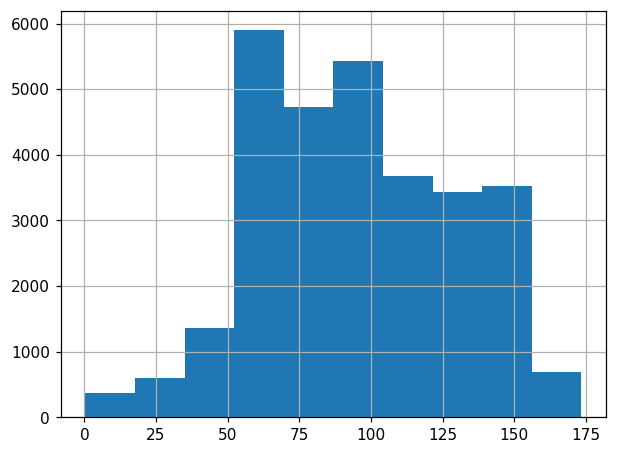

In [514]:
df['Nabenhoehe'].hist()

In [491]:
df[df['Nabenhoehe'].isna()]

,Land,Bundesland,Landkreis,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem
108,Deutschland,Niedersachsen,Nienburg (Weser),31592,Stolzenau,8.987413,52.485784,2019-02-04,2002-02-28,In Betrieb,Wind,600.0,600.0,NaN,Volleinspeisung,Auf dem Acker,Windkraft an Land,NaN,Horizontalläufer,Enercon-40/6.44,NaN,NaN,NaN
125,Deutschland,Bayern,Oberallgäu,87488,Betzigau,NaN,NaN,2019-04-09,2019-01-23,In Betrieb,Wind,1.0,1.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),NaN,Windkraft an Land,FuSystems SkyWind GmbH,Vertikalläufer,NG,NaN,1.5,NaN
177,Deutschland,Niedersachsen,Aurich,26529,Upgant-Schott,7.200870,53.509760,2019-02-05,2012-01-16,In Betrieb,Wind,800.0,800.0,NaN,Volleinspeisung,E-53,Windkraft an Land,ENERCON GmbH,Horizontalläufer,Enercon E-53,NaN,53.0,NaN
219,Deutschland,Niedersachsen,Aurich,26529,Upgant-Schott,7.243216,53.502987,2019-02-05,2009-04-20,In Betrieb,Wind,2300.0,2300.0,0.0,Volleinspeisung,E-70,Windkraft an Land,ENERCON GmbH,Horizontalläufer,Enercon E-70 E4,NaN,71.0,NaN
237,Deutschland,Schleswig-Holstein,Rendsburg-Eckernförde,24229,Schwedeneck,10.096044,54.458812,2019-02-06,2000-04-13,In Betrieb,Wind,1500.0,1500.0,NaN,Volleinspeisung,Bürgerwindpark Schwedeneck GmbH＆Co.KG,Windkraft an Land,Tacke GmbH & Co. KG,Vertikalläufer,"TW 1,5s",NaN,70.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34063,Deutschland,Niedersachsen,Rotenburg (Wümme),27404,Gyhum,9.173500,53.133100,2023-03-06,2002-01-16,In Betrieb,Wind,600.0,600.0,NaN,Volleinspeisung,WP Gyhum,Windkraft an Land,ENERCON GmbH,Horizontalläufer,E44,NaN,44.0,0.0
34121,Deutschland,Hessen,Darmstadt-Dieburg,64372,Ober-Ramstadt,NaN,NaN,2023-03-23,2015-06-22,In Betrieb,Wind,5.0,5.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),NaN,Windkraft an Land,Sonstige,Vertikalläufer,ENW-M,NaN,1.4,0.0
34181,Deutschland,Bayern,Weißenburg-Gunzenhausen,91781,Weißenburg,NaN,NaN,2023-05-06,2023-03-27,In Betrieb,Wind,1.0,1.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Wohngebäude,Windkraft an Land,SkyWind GmbH,Vertikalläufer,SkyWind NG,NaN,1.5,0.0
34314,Deutschland,Bayern,Günzburg,86470,Thannhausen,NaN,NaN,2023-04-21,2023-01-01,In Betrieb,Wind,0.8,0.8,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Skywind,Windkraft an Land,SkyWind GmbH,Vertikalläufer,SkyWind NG,NaN,1.5,0.0


In [497]:
df_postcodes_coords.loc[df_postcodes_coords['postcode'] == 25853]['latitude']

1835    54.580738
Name: latitude, dtype: float64

In [488]:
df_postcodes_coords[df_postcodes_coords['postcode'] == 46325]

,postcode,latitude,longitude
3313,46325,51.844128,6.85722


In [486]:
df_coords_missing[['Postleitzahl', 'Laengengrad', 'Breitengrad']].apply(
    add_coords_using_postcode, axis=1, df_postcodes_coords=df_postcodes_coords).sample(5)

,Postleitzahl,Laengengrad,Breitengrad
28424,84189.0,12.326094,48.353502
31221,55758.0,7.255281,49.812401
31633,97522.0,10.588187,49.987406
4715,32609.0,8.669796,52.267005
25194,46325.0,6.857220,51.844128


In [484]:
df_coords_missing.loc[:, ['Postleitzahl', 'Laengengrad', 'Breitengrad']]

,Postleitzahl,Laengengrad,Breitengrad
39,25853,9.046338,54.580738
79,26169,7.858544,53.023272
97,25873,9.148807,54.449869
119,27232,8.796595,52.665789
123,27232,8.796595,52.665789
...,...,...,...
34318,34626,9.360363,50.877275
34324,66399,7.160266,49.194344
34335,99438,11.267888,50.896747
34361,26409,7.733722,53.595727


In [504]:
df_coords_missing.isna().sum()

Land                                    0
Bundesland                              0
Landkreis                               0
Postleitzahl                            0
Ort                                     0
Laengengrad                             1
Breitengrad                             1
Registrierungsdatum                     0
Inbetriebnahmedatum                     0
EinheitBetriebsstatus                   0
Energietraeger                          0
Bruttoleistung                          0
Nettonennleistung                       0
AnschlussAnHoechstOderHochSpannung    839
Einspeisungsart                        13
NameWindpark                          156
Lage                                    0
Hersteller                             38
Technologie                             0
Typenbezeichnung                       39
Nabenhoehe                            161
Rotordurchmesser                       28
Rotorblattenteisungssystem            154
dtype: int64

In [283]:
# turbine with postcode 99095 and coords
df[(df['Postleitzahl'] == 99095) & df['Laengengrad']]

,Land,Bundesland,Landkreis,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem
29635,Deutschland,Thüringen,Erfurt,99095,Erfurt,11.082553,51.026456,2021-01-10,2013-07-19,In Betrieb,Wind,800.0,800.0,NaN,Volleinspeisung,Kerspleben 2,Windkraft an Land,ENERCON GmbH,Horizontalläufer,E53,73.0,52.9,0.0


In [304]:
df[(df['Postleitzahl'] == 99095) & (df['Laengengrad'])]['Laengengrad'].values.item()

11.082553

In [305]:
df[(df['Postleitzahl'] == 99095) & (df['Laengengrad'])]['Breitengrad'].values.item()

51.026456

In [316]:
# turbine with postcode 99095 but missing coords
df[(df['Postleitzahl'] == 99095) & (df['Laengengrad'].isna())]

,Land,Bundesland,Landkreis,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem
23688,Deutschland,Thüringen,Erfurt,99095,Erfurt,NaN,NaN,2020-09-26,2021-03-25,Vorübergehend stillgelegt,Wind,2.02,2.02,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Garten,Windkraft an Land,Sonstige,Vertikalläufer,Tesup Atlas2.0,NaN,1.2,0.0


In [309]:
df.iloc[df[(df['Postleitzahl'] == 99095) & (df['Laengengrad'].isna())].index]

,Land,Bundesland,Landkreis,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem
24951,Deutschland,Sachsen-Anhalt,Harz,39397,Schwanebeck,11.1209,51.9995,2020-10-29,2003-12-20,In Betrieb,Wind,1500.0,1500.0,0.0,Volleinspeisung,Schwanebeck,Windkraft an Land,NEG Micon Deutschland GmbH,Horizontalläufer,Vestas NM82-1500,93.0,82.0,0.0


In [246]:
df_coords_missing['EinheitBetriebsstatus'].value_counts()

EinheitBetriebsstatus
In Betrieb                   793
Endgültig stillgelegt         39
Vorübergehend stillgelegt      7
Name: count, dtype: int64

<Axes: xlabel='Inbetriebnahmedatum'>

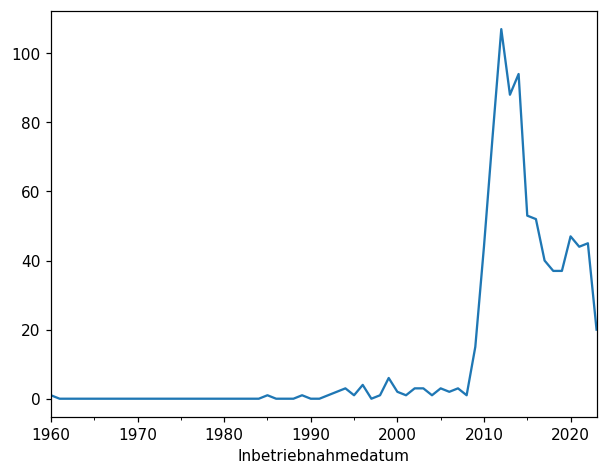

In [244]:
df_coords_missing.resample('A', on='Inbetriebnahmedatum')['Inbetriebnahmedatum'].count().plot()

In [232]:
df_coords_missing['Inbetriebnahmedatum']

39       2012-01-03
79       2018-05-22
97       2018-04-24
119      2017-01-20
123      2017-01-20
            ...    
34318    2023-04-01
34324    2023-04-21
34335    2023-05-01
34361    2023-02-06
34477    2022-12-01
Name: Inbetriebnahmedatum, Length: 839, dtype: object

In [198]:
df['Land'].value_counts()

Land
Deutschland    30459
Name: count, dtype: int64

In [199]:
df['Land'].eq('Deutschland').all()

True

In [204]:
df['Energietraeger'].value_counts()

Energietraeger
Wind    30459
Name: count, dtype: int64

In [192]:
df['NameWindpark'].value_counts()

NameWindpark
Bürgerwindpark Reußenköge GmbH ＆ Co. KG    87
Windpark Midlum                            70
Windrad                                    54
Drohndorf                                  53
Dahme                                      51
                                           ..
Windkraft 931993719                         1
Polaris 1                                   1
Windenergieanlage Lützenreuth               1
Windenergieanlage Zweifelsheim              1
Güterberg Wind                              1
Name: count, Length: 10612, dtype: int64

### Missing data
- Note: Inbetriebnahmedatum missing values because these turbines have status EinheitBetriebsstatus = In Planung
    - That means we have full data for Inbetriebnahmedatum since we filter out turbines in planning!

In [179]:
df.isna().sum()

Land                                      0
Bundesland                                0
Landkreis                                 0
Postleitzahl                              0
Ort                                       0
Laengengrad                             895
Breitengrad                             895
Registrierungsdatum                       0
Inbetriebnahmedatum                    2241
EinheitBetriebsstatus                     0
Energietraeger                            0
Bruttoleistung                            0
Nettonennleistung                         0
AnschlussAnHoechstOderHochSpannung     9509
Einspeisungsart                         652
NameWindpark                            807
Lage                                      0
Hersteller                              330
Technologie                               0
Typenbezeichnung                        346
Nabenhoehe                              761
Rotordurchmesser                        386
Rotorblattenteisungssystem      

In [157]:
df.head(2)

,Land,Bundesland,Landkreis,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem,GeplantesInbetriebnahmedatum,Seelage,ClusterNordsee,Wassertiefe,Kuestenentfernung,ClusterOstsee
0,Deutschland,Hessen,Werra-Meißner-Kreis,34298.0,Helsa,9.739374,51.270068,2019-02-13,2017-09-01,In Betrieb,Wind,3000.0,3000.0,1.0,Volleinspeisung,Windpark Kreuzstein,Windkraft an Land,ENERCON GmbH,Horizontalläufer,E-115,149.08,115.71,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Deutschland,Schleswig-Holstein,Segeberg,23824.0,Damsdorf,10.299400,54.073831,2019-02-01,2017-09-28,In Betrieb,Wind,3000.0,3000.0,0.0,Volleinspeisung,Damsdorf,Windkraft an Land,ENERCON GmbH,Horizontalläufer,E-115,135.40,115.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dates

In [158]:
# Convert date features to datetime objects
# df['Registrierungsdatum'] = pd.to_datetime(df['Registrierungsdatum'])
# df['Inbetriebnahmedatum'] = pd.to_datetime(df['Inbetriebnahmedatum'])

#### Date range of Registrierungsdatum is Jan 2019 to May 2023

In [159]:
# df.sort_values(by='Registrierungsdatum', ascending=True)

In [160]:
print(df['Registrierungsdatum'].min())
print(df['Registrierungsdatum'].max())

2019-01-31 00:00:00
2023-05-26 00:00:00


In [161]:
# Resample on datetime
# Alternative using groupby: df.groupby(pd.Grouper(freq='W', key='Registrierungsdatum'))['Registrierungsdatum'].count()
df.resample('A', on='Registrierungsdatum')['Registrierungsdatum'].count()

Registrierungsdatum
2019-12-31    13176
2020-12-31    14736
2021-12-31     3986
2022-12-31     1633
2023-12-31      953
Freq: A-DEC, Name: Registrierungsdatum, dtype: int64

In [234]:
df.resample('A', on='Registrierungsdatum')['Registrierungsdatum'].count().plot.bar()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

#### Date range of Inbetriebnahmedatum is 1960 to 2023
- Process for registering 

In [163]:
print(df['Inbetriebnahmedatum'].min())
print(df['Inbetriebnahmedatum'].max())

1960-04-02 00:00:00
2023-05-26 00:00:00


<Axes: title={'center': 'Test'}, xlabel='Inbetriebnahmedatum'>

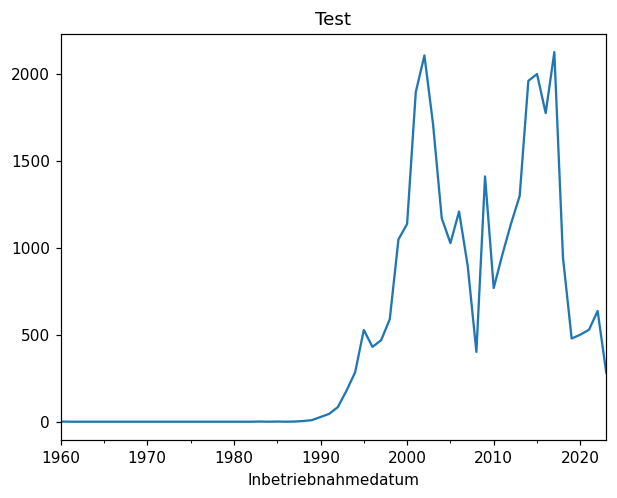

In [164]:
df.resample('A', on='Inbetriebnahmedatum')['Inbetriebnahmedatum'].count().plot(title='Test')

<Axes: title={'center': 'Test'}, xlabel='Inbetriebnahmedatum'>

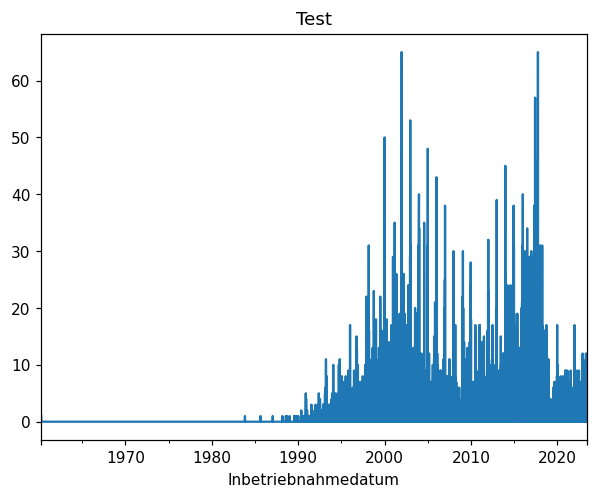

In [165]:
df.resample('D', on='Inbetriebnahmedatum')['Inbetriebnahmedatum'].count().plot(title='Test')

### Unique value counts

In [19]:
df['Energietraeger'].value_counts()

Energietraeger
Wind    34484
Name: count, dtype: int64

In [20]:
df['Technologie'].value_counts()

Technologie
Horizontalläufer    34027
Vertikalläufer        457
Name: count, dtype: int64

In [21]:
df['EinheitBetriebsstatus'].value_counts()

EinheitBetriebsstatus
In Betrieb                   30983
In Planung                    2464
Endgültig stillgelegt          999
Vorübergehend stillgelegt       38
Name: count, dtype: int64

In [40]:
# Land vs offshore
df['Lage'].value_counts()

Lage
Windkraft an Land    32700
Windkraft auf See     1784
Name: count, dtype: int64

In [41]:
df['AnschlussAnHoechstOderHochSpannung'].value_counts()

AnschlussAnHoechstOderHochSpannung
0.0    15554
1.0     9077
Name: count, dtype: int64

In [43]:
df['Hersteller'].value_counts()

Hersteller
ENERCON GmbH                        13057
Vestas Deutschland GmbH              6600
Nordex Energy GmbH                   2228
Siemens Wind Power GmbH & Co. KG     1531
Senvion Deutschland GmbH             1495
                                    ...  
Svit Vitru                              1
ESPV-TEC GmbH & Co. KG                  1
SMA Solar Technology AG                 1
WES IBS GmbH                            1
SB Energy UK Ltd.                       1
Name: count, Length: 115, dtype: int64

### Summary statistics of numerical continuous features
- Looks like I'll want wind speed data for height 100m

In [50]:
df[['Bruttoleistung', 'Nettonennleistung', 'Nabenhoehe', 'Rotordurchmesser']].describe()

,Bruttoleistung,Nettonennleistung,Nabenhoehe,Rotordurchmesser
count,34484.000000,34484.000000,33631.000000,34031.000000
mean,2370.309200,2370.309200,98.725831,87.096264
std,1681.910702,1681.910702,34.785787,35.863944
min,0.120000,0.120000,0.360000,0.300000
25%,1500.000000,1500.000000,70.000000,66.000000
50%,2000.000000,2000.000000,98.000000,82.000000
75%,3050.000000,3050.000000,134.000000,115.000000
max,20000.000000,20000.000000,200.000000,200.000000


### Create a date range/index and group turbine records on date they went into operation
- Also aggregate some of the other columns on grouped days as well (e.g. average blade diameter, etc)

In [173]:
df[df['Laengengrad'].isna() & (df['EinheitBetriebsstatus'] != 'In Betrieb')]

,Land,Bundesland,Landkreis,Postleitzahl,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,Einspeisungsart,NameWindpark,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem,GeplantesInbetriebnahmedatum,Seelage,ClusterNordsee,Wassertiefe,Kuestenentfernung,ClusterOstsee
97,Deutschland,Schleswig-Holstein,Nordfriesland,25873.0,Rantrum,NaN,NaN,2019-02-04,2018-04-24,Endgültig stillgelegt,Wind,10.0,10.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),PSW,Windkraft an Land,PSW-Energiesysteme GmbH,Horizontalläufer,EN-Drive 2000.3 M,10.0,7.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2194,Deutschland,Niedersachsen,Uelzen,29584.0,Himbergen,NaN,NaN,2019-03-03,2019-02-20,Endgültig stillgelegt,Wind,10.0,10.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Kleinwindkraftanlage,Windkraft an Land,PSW-Energiesysteme GmbH,Vertikalläufer,EN-Drive 2000.3 - 10 kW,NaN,7.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2463,Deutschland,Bayern,Oberallgäu,87499.0,Wildpoldsried,NaN,NaN,2019-03-10,NaT,In Planung,Wind,1.4,1.4,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Wind of Change,Windkraft an Land,Sonstige,Horizontalläufer,Wind of Change 1400,12.1,1.40,NaN,2022-06-03,NaN,NaN,NaN,NaN,NaN
4464,Deutschland,Schleswig-Holstein,Schleswig-Flensburg,24989.0,Dollerup,NaN,NaN,2019-04-30,2019-04-16,Endgültig stillgelegt,Wind,7.5,7.5,NaN,Teileinspeisung (einschließlich Eigenverbrauch),NaN,Windkraft an Land,Weinack Windenergie Anlagen GmbH,Horizontalläufer,WWA Falcon 40,18.0,7.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4715,Deutschland,Nordrhein-Westfalen,Minden-Lübbecke,32609.0,Hüllhorst,NaN,NaN,2019-05-05,2015-07-12,Endgültig stillgelegt,Wind,1.2,1.2,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Windrad,Windkraft an Land,K.D.-Stahl- und Maschinenbau GmbH,Vertikalläufer,Amperius,NaN,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34333,Deutschland,Schleswig-Holstein,Dithmarschen,25764.0,Wesselburenerkoog,NaN,NaN,2023-05-01,NaT,In Planung,Wind,6.0,6.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),vertikal,Windkraft an Land,Sonstige,Horizontalläufer,Bayoung-FH3.6M-NEW,9.0,3.00,0.0,2023-09-01,NaN,NaN,NaN,NaN,NaN
34334,Deutschland,Schleswig-Holstein,Nordfriesland,25882.0,Tetenbüll,NaN,NaN,2023-05-03,NaT,In Planung,Wind,1.0,1.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),NaN,Windkraft an Land,SkyWind GmbH,Horizontalläufer,SkyWind NG,8.0,1.50,0.0,2023-05-22,NaN,NaN,NaN,NaN,NaN
34336,Deutschland,Niedersachsen,Uelzen,29571.0,Rosche,NaN,NaN,2023-05-06,NaT,In Planung,Wind,0.6,0.6,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Sky Wind Dachanlage,Windkraft an Land,SkyWind GmbH,Horizontalläufer,Sky Wind NG,9.0,1.35,0.0,2023-06-10,NaN,NaN,NaN,NaN,NaN
34340,Deutschland,Nordrhein-Westfalen,Dortmund,44269.0,Dortmund,NaN,NaN,2023-05-08,NaT,In Planung,Wind,2.0,2.0,NaN,Teileinspeisung (einschließlich Eigenverbrauch),Conciso - Windpark,Windkraft an Land,SkyWind GmbH,Horizontalläufer,SkyWind NG 1kW,163.0,1.00,0.0,2023-06-30,NaN,NaN,NaN,NaN,NaN
